# Distinguishing Reality: Classifying Real vs. AI-Generated Images
In this notebook, we will explore the task of classifying images as real or AI-generated using fine-tuning techniques with several well-known CNN architectures. For this classification task, we will use the CIFAKE dataset, which includes both real and AI-generated images.

Link for the dataset: [CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)

### Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import os
from collections import Counter
import torch 
from torchvision import datasets, transforms
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim
from glob import glob 
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from utils_function import *

### Device Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available
print("Device:", device)  # Print device

if device.type == "cuda":  # If GPU is available
    print(torch.cuda.get_device_name(0))  # Print the GPU name
    print("Memory Allocated:", torch.cuda.memory_allocated(0) / 1024 ** 2, "MB")  # Print the allocated memory
    print("Memory Cached:", torch.cuda.memory_reserved(0) / 1024 ** 2, "MB")  # Print the cached memory

Device: cpu


In [70]:
# If using multiple GPUs
device = torch.device("cuda:1")
print("Device:", device)  # Print device

Device: cuda:1


In [71]:
# clear GPU memory
torch.cuda.empty_cache()

### Data preparation

In [5]:
from image_dataset import Image_Dataset

img_height = 224
img_width = 224

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
# train_set = glob("./dataset/train/*/*")
train_dataset = Image_Dataset("./dataset/train/", transform=transform)

# test_set = glob("./dataset/test/*/*")
test_dataset = Image_Dataset("./dataset/test/", transform=transform)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_ds, valid_ds = train_dataset.split_dataset(train_size=0.8)

Train dataset size: 100000
Test dataset size: 20000


In [6]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Original length of the dataset
print("Original length of the training dataset:", len(train_ds))
print("Original length of the validation dataset:", len(valid_ds))
print("Original length of the test dataset:", len(test_dataset))
# Length of the dataloaders
print("Length of the training dataloader:", len(train_loader))
print("Length of the validation dataloader:", len(val_loader))
print("Length of the test dataloader:", len(test_loader))

Original length of the training dataset: 80000
Original length of the validation dataset: 20000
Original length of the test dataset: 20000
Length of the training dataloader: 625
Length of the validation dataloader: 157
Length of the test dataloader: 157


In [ ]:
count_classes(train_loader)
count_classes(val_loader)
count_classes(test_loader)

Feature batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


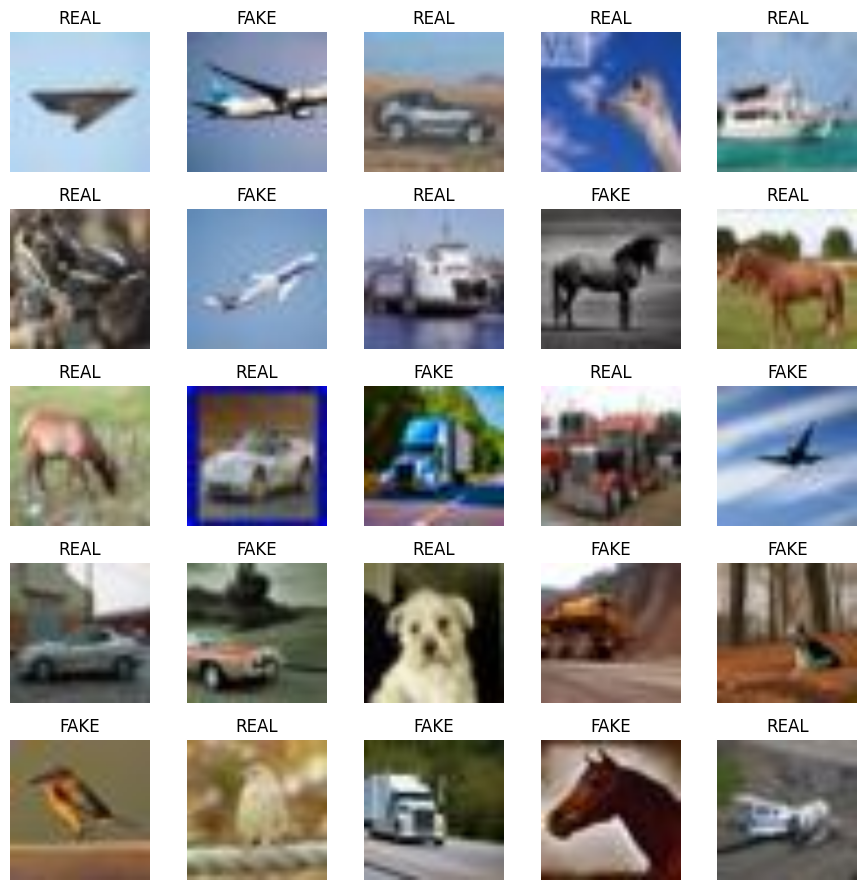

In [48]:
# display 5*5 images
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# display 5*5 images

plot_images(train_features, train_labels)

## Pretrained Model Transfer Learning

In [7]:
def check_accuracy(val_loader, model):
    # print('Checking accuracy on val set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            # Assuming binary classification output
            preds = (scores >= 0.5).float()  # Convert scores to binary predictions

            num_correct += (preds.view(-1) == y.view(-1)).sum().item()  # Ensure both are flat
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples if num_samples > 0 else 0  # Avoid division by zero
    return 100 * acc

In [8]:
def train_loop(model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_losses = []
    val_accuracies = []
    train_acc = []

    for e in range(1, epochs + 1):
        model.train()  # put model to training mode
        num_correct = 0
        num_samples = 0
        total_loss = 0

        with tqdm(train_loader, unit="batch", desc=f"Epoch {e}/{epochs}") as tepoch:
            for t, (x, y) in enumerate(tepoch):
                x = x.to(device=device)  # move to device, e.g. GPU
                y = y.to(device=device).view(-1, 1).float()  # Ensure y has correct shape

                optimizer.zero_grad()  # Zero out gradients
                scores = model(x)
                loss = torch.nn.BCELoss()(scores, y)  # Compute loss

                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                train_losses.append(loss.item())
                total_loss += loss.item()

                # Calculate training accuracy
                preds = (scores >= 0.5).float()  # Convert scores to binary predictions
                num_correct += (preds.view(-1) == y.view(-1)).sum().item()
                num_samples += preds.size(0)

                train_accuracy = num_correct / num_samples * 100
                train_acc.append(train_accuracy)

                tepoch.set_postfix(loss=loss.item(), train_accuracy=train_accuracy)

        # Check validation accuracy at the end of the epoch
        v_accuracy = check_accuracy(val_loader, model)
        val_accuracies.append(v_accuracy)
        print(f"Epoch {e} validation accuracy: {v_accuracy:.2f}%")
        
        # Optionally add a learning rate scheduler here

    return train_losses, val_accuracies, train_acc

In [11]:
from model.ResNet import ResNetTransferLearning
from model.VGG16 import VGGTransferLearning
from model.EfficientNet import EfficientNetTransferLearning
from model.MobileNet import MobileNetTransferLearning
from model.ViT import ViTTransferLearning

### ResNet

In [ ]:

ResNet_model = ResNetTransferLearning(img_height=224, img_width=224)
# print(ResNet_model)
summary(ResNet_model, (1, 3, img_height, img_width))

In [ ]:
optimizer_res = torch.optim.Adam(ResNet_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_res, val_accuracies_res, train_accuracies_res = train_loop(ResNet_model, optimizer_res, epochs=10)

# Training and Validation Time: 27m 56.2s

In [ ]:
# Save the model weights
ResNet_model.save_model("./model_weight/ResNet_model.pth")

# Save the metrics
save_metrics("ResNet", train_losses_res, val_accuracies_res, train_accuracies_res)

In [ ]:

ResNet_model2 = ResNetTransferLearning(img_height=224, img_width=224)
optimizer_res2 = torch.optim.SGD(ResNet_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_res2, val_accuracies_res2, train_accuracies_res2 = train_loop(ResNet_model2, optimizer_res2, epochs=10)

# Training and Validation Time: 27m 25.6s

In [ ]:
# Save the model weights
ResNet_model2.save_model("./model_weight/ResNet_model2.pth")

# Save the metrics
save_metrics("ResNet2", train_losses_res2, val_accuracies_res2, train_accuracies_res2)

### VGG16

In [17]:

# Create an instance of the model
VGG_model = VGGTransferLearning(img_height=224, img_width=224)

# print(VGG_model)
summary(VGG_model, (1, 3, img_height, img_width))


Layer (type:depth-idx)                   Output Shape              Param #
VGGTransferLearning                      [1, 1]                    --
├─VGG: 1-1                               [1, 512]                  --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]          --

In [ ]:

optimizer_vgg = torch.optim.Adam(VGG_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_vgg, val_accuracies_vgg, train_accuracies_vgg = train_loop(VGG_model, optimizer_vgg, epochs=10)

# Training and Validation Time: 41m 49.4s

In [ ]:
# Save the model weights
VGG_model.save_model("./model_weight/VGG_model.pth")

# Save the metrics
save_metrics("VGG", train_losses_vgg, val_accuracies_vgg, train_accuracies_vgg)

In [ ]:

# Create an instance of the model
VGG_model2 = VGGTransferLearning(img_height=224, img_width=224)

optimizer_vgg2 = torch.optim.SGD(VGG_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_vgg2, val_accuracies_vgg2, train_accuracies_vgg2 = train_loop(VGG_model2, optimizer_vgg2, epochs=10)

# Training and Validation Time: 42m 13.0s

In [ ]:
# Save the model weights
VGG_model2.save_model("./model_weight/VGG_model2.pth")

# Save the metrics
save_metrics("VGG2", train_losses_vgg2, val_accuracies_vgg2, train_accuracies_vgg2)

### EfficientNet

In [ ]:

# Create an instance of the model
Eff_model = EfficientNetTransferLearning(img_height, img_width)
# print(Eff_model)

summary(Eff_model, (1, 3, img_height, img_width))


In [ ]:

optimizer_eff = torch.optim.Adam(Eff_model.parameters(), lr=0.001, weight_decay = 0.005)

train_losses_eff, val_accuracies_eff, train_accuracies_eff = train_loop(Eff_model, optimizer_eff, epochs=10)

# Training and Validation Time: 30m 37.0s

In [ ]:
# Save the model weights
Eff_model.save_model("./model_weight/Eff_model.pth")

# Save the metrics
save_metrics("Eff", train_losses_eff, val_accuracies_eff, train_accuracies_eff)

In [ ]:

# Create an instance of the model
Eff_model2 = EfficientNetTransferLearning(img_height, img_width)

optimizer_eff2 = torch.optim.SGD(Eff_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)

train_losses_eff2, val_accuracies_eff2, train_accuracies_eff2 = train_loop(Eff_model2, optimizer_eff2, epochs=10)

# Training and Validation Time: 30m 14.6s

In [ ]:
# Save the model weights
Eff_model2.save_model("./model_weight/Eff_model2.pth")

# Save the metrics
save_metrics("Eff2", train_losses_eff2, val_accuracies_eff2, train_accuracies_eff2)

### MobileNet

In [16]:

# Create an instance of the model
Mobile_model = MobileNetTransferLearning(img_height, img_width)

# print(Mobile_model)

summary(Mobile_model, (1, 3, img_height, img_width))

Layer (type:depth-idx)                                  Output Shape              Param #
MobileNetTransferLearning                               [1, 1]                    --
├─MobileNetV3: 1-1                                      [1, 576]                  --
│    └─Sequential: 2-1                                  [1, 576, 7, 7]            --
│    │    └─Conv2dNormActivation: 3-1                   [1, 16, 112, 112]         464
│    │    └─InvertedResidual: 3-2                       [1, 16, 56, 56]           744
│    │    └─InvertedResidual: 3-3                       [1, 24, 28, 28]           3,864
│    │    └─InvertedResidual: 3-4                       [1, 24, 28, 28]           5,416
│    │    └─InvertedResidual: 3-5                       [1, 40, 14, 14]           13,736
│    │    └─InvertedResidual: 3-6                       [1, 40, 14, 14]           57,264
│    │    └─InvertedResidual: 3-7                       [1, 40, 14, 14]           57,264
│    │    └─InvertedResidual: 3-8       

In [ ]:

optimizer_mobile = torch.optim.Adam(Mobile_model.parameters(), lr=0.001, weight_decay = 0.005)

train_losses_mobile, val_accuracies_mobile, train_accuracies_mobile = train_loop(Mobile_model, optimizer_mobile, epochs=10)

# Training and Validation Time: 10m 40.5s

In [ ]:
# Save the model weights
Mobile_model.save_model("./model_weight/MobileNet_model.pth")

# Save the metrics
save_metrics("MobileNet", train_losses_mobile, val_accuracies_mobile, train_accuracies_mobile)

In [ ]:
# Create an instance of the model
Mobile_model2 = MobileNetTransferLearning(img_height, img_width)


optimizer_mobile2 = torch.optim.SGD(Mobile_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)

train_losses_mobile2, val_accuracies_mobile2, train_accuracies_mobile2 = train_loop(Mobile_model2, optimizer_mobile2, epochs=10)

# Training and Validation Time: 10m 44.8s

In [ ]:
# Save the model weights
Mobile_model2.save_model("./model_weight/MobileNet_model2.pth")

# Save the metrics
save_metrics("MobileNet2", train_losses_mobile2, val_accuracies_mobile2, train_accuracies_mobile2)

### Vision Transformer (ViT)

In [ ]:


# Create an instance of the model
ViT_model = ViTTransferLearning(img_height, img_width)

# print(ViT_model)

summary(ViT_model, (1, 3, img_height, img_width))

In [ ]:

optimizer_vit = torch.optim.Adam(ViT_model.parameters(), lr=0.001, weight_decay = 0.005)

train_losses_vit, val_accuracies_vit, train_accuracies_vit = train_loop(ViT_model, optimizer_vit, epochs=10)

# Training and Validation Time: 58m 34.1s

In [ ]:
# Save the model weights
ViT_model.save_model("./model_weight/ViT_model.pth")

# Save the metrics
save_metrics("ViT", train_losses_vit, val_accuracies_vit, train_accuracies_vit)

In [ ]:
from ViT import ViTTransferLearning

# Create an instance of the model
ViT_model2 = ViTTransferLearning(img_height, img_width)

optimizer_vit2 = torch.optim.SGD(ViT_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)

train_losses_vit2, val_accuracies_vit2, train_accuracies_vit2 = train_loop(ViT_model2, optimizer_vit2, epochs=10)

# Training and Validation Time: 78m 30.10

In [ ]:
# Save the model weights
ViT_model2.save_model("./model_weight/ViT_model2.pth")

# Save the metrics
save_metrics("ViT2", train_losses_vit2, val_accuracies_vit2, train_accuracies_vit2)

## ELA (Error Level Analysis) + CNN

In [52]:
from ela_utils import *

### ELA conversion

In [ ]:
convert_file_images_to_ela(glob("./ela_testing/*"), output_directory='./ela_testing_result')

# show comparison between original and ELA images
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
file_name = ['f1.jpg', 'f2.jpg', 'r1.jpeg', 'r2.jpeg']
for i in range(4):
    for j in range(2):
        if j % 2 == 0:
            img = Image.open(f'./ela_testing/{file_name[i]}')
        else:
            img = Image.open(f'./ela_testing_result/{file_name[i]}') 
        ax[j, i].imshow(img)
        ax[j, i].axis('off')
        if i <= 1 :
            if j == 0:
                ax[j, i].set_title('Fake Original')
            else:
                ax[j, i].set_title('Fake ELA')
        else:
            if j == 0:
                ax[j, i].set_title('Real Original')
            else:
                ax[j, i].set_title('Real ELA')
            
        
plt.show()


### Data preparation

In [ ]:
train_file = glob("./dataset/train/*/*.jpg")
print('total number of train files', len(train_file))

test_file = glob("./dataset/test/*/*.jpg")
print('total number of test files', len(test_file))

convert_file_images_to_ela(glob("./dataset/train/REAL/*.jpg"), output_directory='./ela_dataset/train/REAL')
convert_file_images_to_ela(glob("./dataset/train/FAKE/*.jpg"), output_directory='./ela_dataset/train/FAKE')
convert_file_images_to_ela(glob("./dataset/test/REAL/*.jpg"), output_directory='./ela_dataset/test/REAL')
convert_file_images_to_ela(glob("./dataset/test/FAKE/*.jpg"), output_directory='./ela_dataset/test/FAKE')



In [ ]:

# train_set = glob("./dataset/train/*/*")
train_dataset_ela = Image_Dataset("./ela_dataset/train/", transform=transform)

# test_set = glob("./dataset/test/*/*")
test_dataset_ela = Image_Dataset("./ela_dataset/test/", transform=transform)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

train_ds_ela, valid_ds_ela = train_dataset_ela.split_dataset(train_size=0.8)

In [ ]:
ela_train_loader = DataLoader(train_ds_ela, batch_size=128, shuffle=True)
ela_val_loader = DataLoader(valid_ds_ela, batch_size=128, shuffle=False)
ela_test_loader = DataLoader(test_dataset_ela, batch_size=128, shuffle=False)

# Original length of the dataset
print("Original length of the training dataset:", len(train_ds_ela))
print("Original length of the validation dataset:", len(valid_ds_ela))
print("Original length of the test dataset:", len(test_dataset_ela))
# Length of the dataloaders
print("Length of the training dataloader:", len(ela_train_loader))
print("Length of the validation dataloader:", len(ela_val_loader))
print("Length of the test dataloader:", len(ela_test_loader))


In [ ]:
# Count the number of each class in the dataset
count_classes(ela_train_loader)
count_classes(ela_val_loader)
count_classes(ela_test_loader)

In [ ]:
# display 5*5 images
train_features, train_labels = next(iter(ela_train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# display 5*5 images
plot_images(train_features, train_labels)


### CNN

In [ ]:
from model.CNN import CNNModel

CNN_model = CNNModel(img_height=224, img_width=224)
# print(cnn_model)
summary(CNN_model, (1, 3, img_height, img_width))

In [ ]:

optimizer_cnn = torch.optim.Adam(CNN_model.parameters(), lr=0.001, weight_decay = 0.005)
train_losses_cnn, val_accuracies_cnn, train_accuracies_cnn = train_loop(CNN_model, optimizer_cnn, epochs=10)

# Training and Validation Time: 41m 49.4s

In [ ]:
# Save the model weights
CNN_model.save_model("./model_weight/CNN_model.pth")

# Save the metrics
save_metrics("CNN", train_losses_cnn, val_accuracies_cnn, train_accuracies_cnn)

In [ ]:

# Create an instance of the model
CNN_model2 = CNNModel(img_height=224, img_width=224)

optimizer_cnn2 = torch.optim.SGD(CNN_model2.parameters(), lr=0.001, weight_decay = 0.005, momentum=0.9)
train_losses_cnn2, val_accuracies_cnn2, train_accuracies_cnn2 = train_loop(CNN_model2, optimizer_cnn2, epochs=10)

# Training and Validation Time: 42m 13.0s

In [ ]:
# Save the model weights
CNN_model2.save_model("./model_weight/CNN_model2.pth")

# Save the metrics
save_metrics("CNN2", train_losses_cnn2, val_accuracies_cnn2, train_accuracies_cnn2)

## Evaluation on Training

### Training and Validation Time


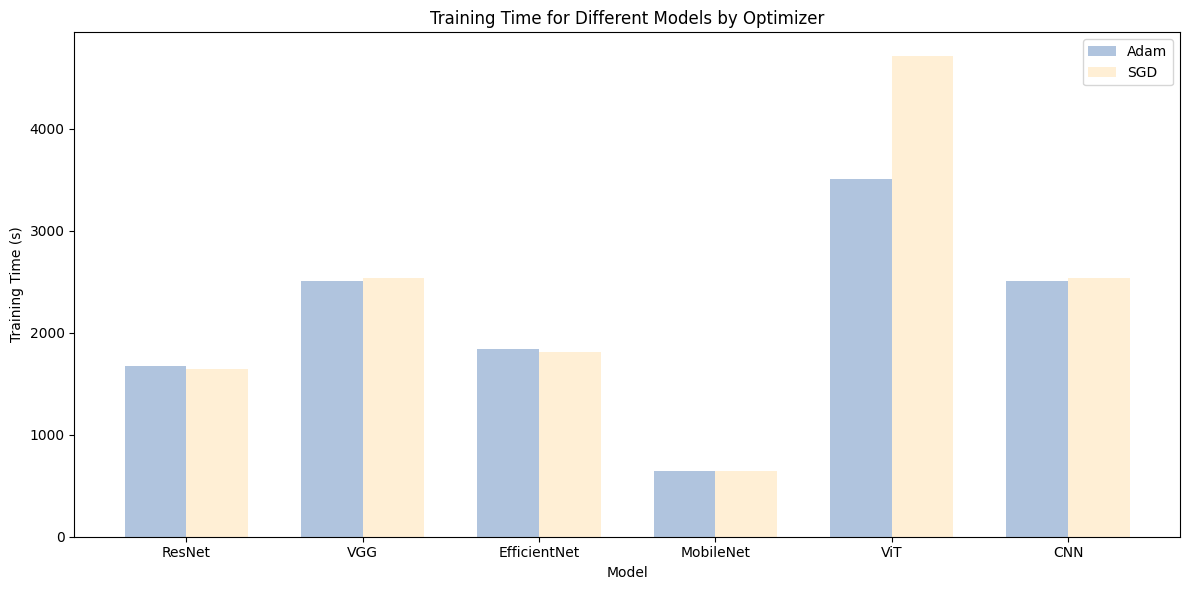

In [40]:

save_training_times_to_csv('./training_result/training_times.csv')

plot_training_time('./training_result/training_times.csv')

### Training and Validation Loss

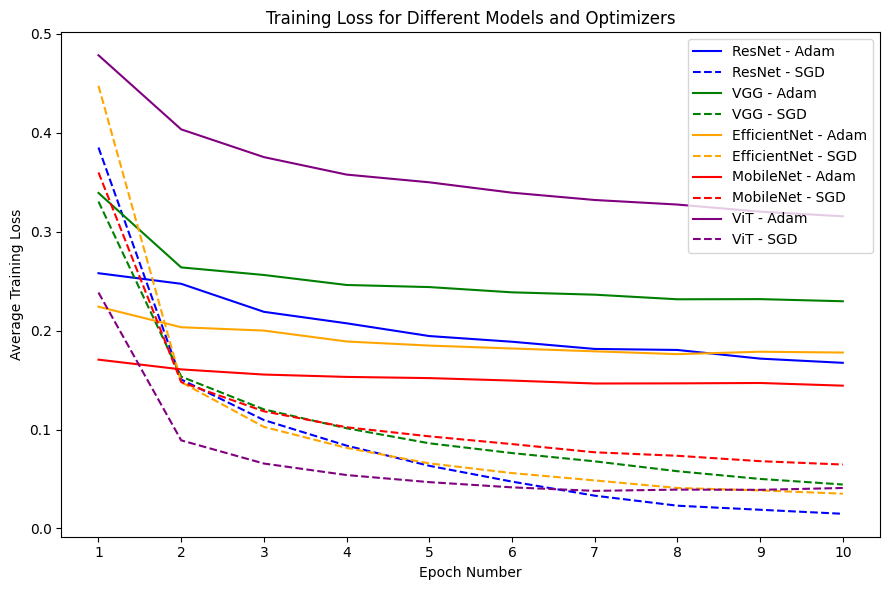

In [37]:

# File paths for each model and optimizer
file_paths_train_loss = {
    'ResNet_Adam': './training_result/ResNet_TrainLoss.csv',
    'ResNet_SGD': './training_result/ResNet2_TrainLoss.csv',
    'VGG_Adam': './training_result/VGG_TrainLoss.csv',
    'VGG_SGD': './training_result/VGG2_TrainLoss.csv',
    'EfficientNet_Adam': './training_result/Eff_TrainLoss.csv',
    'EfficientNet_SGD': './training_result/Eff2_TrainLoss.csv',
    'MobileNet_Adam': './training_result/MobileNet_TrainLoss.csv',
    'MobileNet_SGD': './training_result/MobileNet2_TrainLoss.csv',
    'ViT_Adam': './training_result/ViT_TrainLoss.csv',
    'ViT_SGD': './training_result/ViT2_TrainLoss.csv',
}

# Load loss data
loss_data = {}
for key, path in file_paths_train_loss.items():
    loss_data[key] = load_train_data(path)



# Define models and optimizers
model_names = ['ResNet', 'VGG', 'EfficientNet', 'MobileNet', 'ViT']
optimizer_names = ['Adam', 'SGD']
model_colors = {
    'ResNet': 'blue',
    'VGG': 'green',
    'EfficientNet': 'orange',
    'MobileNet': 'red',
    'ViT': 'purple'
}

# Plot training loss
plot_result(loss_data, model_names, optimizer_names, model_colors, 'Training Loss for Different Models and Optimizers')

### Training and Validation Accuracy

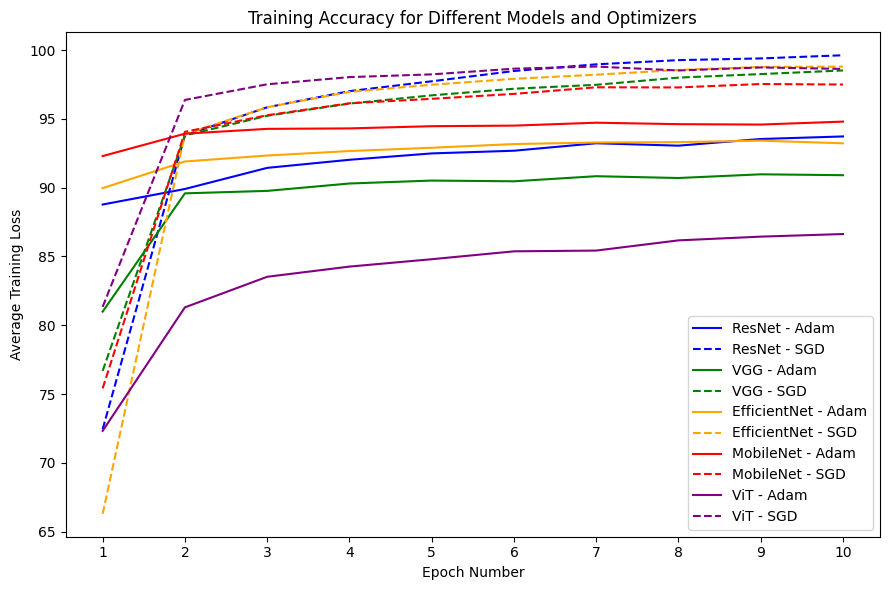

In [38]:

# File paths for each model and optimizer
file_paths_train_acc = {
    'ResNet_Adam': './training_result/ResNet_TrainAcc.csv',
    'ResNet_SGD': './training_result/ResNet2_TrainAcc.csv',
    'VGG_Adam': './training_result/VGG_TrainAcc.csv',
    'VGG_SGD': './training_result/VGG2_TrainAcc.csv',
    'EfficientNet_Adam': './training_result/Eff_TrainAcc.csv',
    'EfficientNet_SGD': './training_result/Eff2_TrainAcc.csv',
    'MobileNet_Adam': './training_result/MobileNet_TrainAcc.csv',
    'MobileNet_SGD': './training_result/MobileNet2_TrainAcc.csv',
    'ViT_Adam': './training_result/ViT_TrainAcc.csv',
    'ViT_SGD': './training_result/ViT2_TrainAcc.csv',
}

# Load loss data
train_acc_data = {}
for key, path in file_paths_train_acc.items():
    train_acc_data[key] = load_train_data(path)

# Plot training loss
plot_result(train_acc_data, model_names, optimizer_names, model_colors, 'Training Accuracy for Different Models and Optimizers')

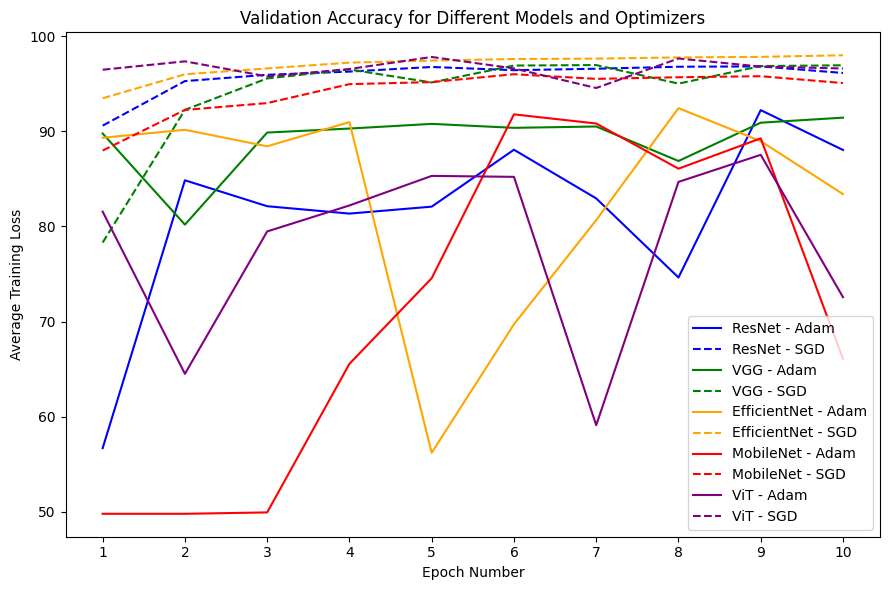

In [39]:

# File paths for each model and optimizer
file_paths_val_acc = {
    'ResNet_Adam': './training_result/ResNet_ValAcc.csv',
    'ResNet_SGD': './training_result/ResNet2_ValAcc.csv',
    'VGG_Adam': './training_result/VGG_ValAcc.csv',
    'VGG_SGD': './training_result/VGG2_ValAcc.csv',
    'EfficientNet_Adam': './training_result/Eff_ValAcc.csv',
    'EfficientNet_SGD': './training_result/Eff2_ValAcc.csv',
    'MobileNet_Adam': './training_result/MobileNet_ValAcc.csv',
    'MobileNet_SGD': './training_result/MobileNet2_ValAcc.csv',
    'ViT_Adam': './training_result/ViT_ValAcc.csv',
    'ViT_SGD': './training_result/ViT2_ValAcc.csv',
}

# Load loss data
val_acc_data = {}
for key, path in file_paths_val_acc.items():
    val_acc_data[key] = load_val_data(path)


# Plot training loss
plot_result(val_acc_data, model_names, optimizer_names, model_colors, 'Validation Accuracy for Different Models and Optimizers')

## Testing

using test set to evaluate the model and get the final accuracy, precision, recall, and F1-score.

In [ ]:
# Function to load the model weights
def load_model(model_class, model_path, device):
    model = model_class(img_height=224, img_width=224)  # Initialize the model using the provided class
    if device.type == "cpu":
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(model_path,  weights_only=True, map_location=device))  # Load weights
    model.to(device)  # Move model to the appropriate device
    return model

def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []   # List to store true labels
    y_pred = []   # List to store predicted labels

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            y_true.extend(labels.cpu().numpy())  # Store true labels
            y_pred.extend(predicted.cpu().numpy())  # Store predictions

    return np.array(y_true), np.array(y_pred)




In [ ]:

# ResNet_Adam_path = './model_weight/ResNet_model.pth'
ResNet_SGD_path = './model_weight/ResNet_model2.pth'
# VGG_Adam_path = './model_weight/VGG_model.pth'
VGG_SGD_path = './model_weight/VGG_model2.pth'
# Eff_Adam_path = './model_weight/Eff_model.pth'
Eff_SGD_path = './model_weight/Eff_model2.pth'
# Mobile_Adam_path = './model_weight/MobileNet_model.pth'
Mobile_SGD_path = './model_weight/MobileNet_model2.pth'
# ViT_Adam_path = './model_weight/ViT_model.pth'
ViT_SGD_path = './model_weight/ViT_model2.pth'


# ResNet_Adam_model = load_model(ResNetTransferLearning, ResNet_Adam_path, device)
ResNet_SGD_model = load_model(ResNetTransferLearning, ResNet_SGD_path, device)
# VGG_Adam_model = load_model(VGGTransferLearning(img_height, img_width), VGG_Adam_path, device)
VGG_SGD_model = load_model(VGGTransferLearning(img_height, img_width), VGG_SGD_path, device)
# Eff_Adam_model = load_model(EfficientNetTransferLearning, Eff_Adam_path, device)
Eff_SGD_model = load_model(EfficientNetTransferLearning, Eff_SGD_path, device)
# Mobile_Adam_model = load_model(MobileNetTransferLearning, Mobile_Adam_path, device)
Mobile_SGD_model = load_model(MobileNetTransferLearning, Mobile_SGD_path, device)
# ViT_Adam_model = load_model(ViTTransferLearning(img_height, img_width), ViT_Adam_path, device)
ViT_SGD_model = load_model(ViTTransferLearning, ViT_SGD_path, device)


In [ ]:

y_true_resnet, y_pred_resnet= evaluate_model(ResNet_SGD_model, test_loader, device)
y_true_vgg, y_pred_vgg = evaluate_model(VGG_SGD_model, test_loader, device)
y_true_eff, y_pred_eff = evaluate_model(Eff_SGD_model, test_loader, device)
y_true_mobile, y_pred_mobile = evaluate_model(Mobile_SGD_model, test_loader, device)
y_true_vit, y_pred_vit = evaluate_model(ViT_SGD_model, test_loader, device)




In [ ]:
plot_confusion_matrix(y_true_resnet, y_pred_resnet, classes=['Fake', 'Real']) # 1 real and 0 fake

## Visualization